# RQ1: Who wants to be a Champion? 

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize  
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import random

# Import data

In [2]:
dataset = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/matches/matches_England.json')

In [3]:
# Take only the columns usefull for this task
sub_dataset = dataset[['status','winner', 'label']] 

In [4]:
# Now I will extract all the information contained in the label column and rearrange it!
label = pd.DataFrame(sub_dataset['label'])

In [5]:
label.head(3)

label
0              Burnley - AFC Bournemouth, 1 - 2
1  Crystal Palace - West Bromwich Albion, 2 - 0
2            Huddersfield Town - Arsenal, 0 - 1

In [6]:
new_dataset = label["label"].str.split(",",n = 1, expand = True) # split the column label

In [7]:
new_dataset.columns = ("teams", "score") # rename the columns

In [8]:
new_dataset.head(3)

teams   score
0              Burnley - AFC Bournemouth   1 - 2
1  Crystal Palace - West Bromwich Albion   2 - 0
2            Huddersfield Town - Arsenal   0 - 1

In [9]:
teams = new_dataset["teams"].str.split("-",n = 1, expand = True) # split the teams column

In [10]:
score = new_dataset["score"].str.split("-",n = 1, expand = True) # split the score column

In [37]:
# merge teams and score to the sub_dataset
final1 = pd.merge(teams, score, left_index=True, right_index=True)
dataset = pd.merge(sub_dataset, final1, left_index=True, right_index=True)

In [38]:
dataset.head(5)

status  winner                                         label  \
0  Played    1659              Burnley - AFC Bournemouth, 1 - 2   
1  Played    1628  Crystal Palace - West Bromwich Albion, 2 - 0   
2  Played    1609            Huddersfield Town - Arsenal, 0 - 1   
3  Played    1612     Liverpool - Brighton & Hove Albion, 4 - 0   
4  Played    1611            Manchester United - Watford, 1 - 0   

                  0_x                      1_x  0_y 1_y  
0            Burnley           AFC Bournemouth   1    2  
1     Crystal Palace      West Bromwich Albion   2    0  
2  Huddersfield Town                   Arsenal   0    1  
3          Liverpool    Brighton & Hove Albion   4    0  
4  Manchester United                   Watford   1    0

In [39]:
dataset.drop(columns = ['label'], inplace=True)

In [40]:
# rename columns
dataset.columns = ("status", "winner", "home", "away", "home_score", "away_score")

In [41]:
dataset.head(2)

status  winner             home                   away home_score  \
0  Played    1659         Burnley         AFC Bournemouth         1    
1  Played    1628  Crystal Palace    West Bromwich Albion         2    

  away_score  
0          2  
1          0

In [42]:
# adjust the name spacing
home = []
for i in dataset['home']:
    j = " ".join(i.split())
    home.append(j)
away = []
for i in dataset['away']:
    j = " ".join(i.split())
    away.append(j)

In [43]:
dataset['home'] = home
dataset['away'] = away

In [44]:
# points assignation
# 3 points to the winning team
# 1 point when there's a draw
# 0 point to the losing team

home_points = []
away_points = []
for i in range(len(dataset["home_score"])):
    if int(dataset["home_score"][i]) == int(dataset["away_score"][i]):
        home_points.append(1)
        away_points.append(1)
    elif int(dataset["home_score"][i]) > int(dataset["away_score"][i]):
        home_points.append(3)
        away_points.append(0)
    else:
        home_points.append(0)
        away_points.append(3)

In [45]:
dataset['home_points'] = home_points

In [46]:
dataset['away_points'] = away_points

In [47]:
# zip the team names and their points in orther to create a new dataset 
from itertools import chain
teams_name = list(chain.from_iterable(zip(dataset["home"], dataset["away"])))
points = list(chain.from_iterable(zip(dataset["home_points"], dataset["away_points"])))

In [48]:
# final dataset
final_dataset = {'teams_name':teams_name,'points':points}
final_dataset = pd.DataFrame(final_dataset)
final_dataset.head(3)

teams_name  points
0          Burnley       0
1  AFC Bournemouth       3
2   Crystal Palace       3

In [49]:
final_dataset = final_dataset.groupby('teams_name')['points'].apply(lambda x: pd.Series(list(x))).unstack()

In [50]:
# change the column names
q = final_dataset.columns      
a = 'week'
b = []
for i in range(1, len(q) +1):
    b.append(a + str(i))
final_dataset.columns = b

In [51]:
final_transp = final_dataset.T

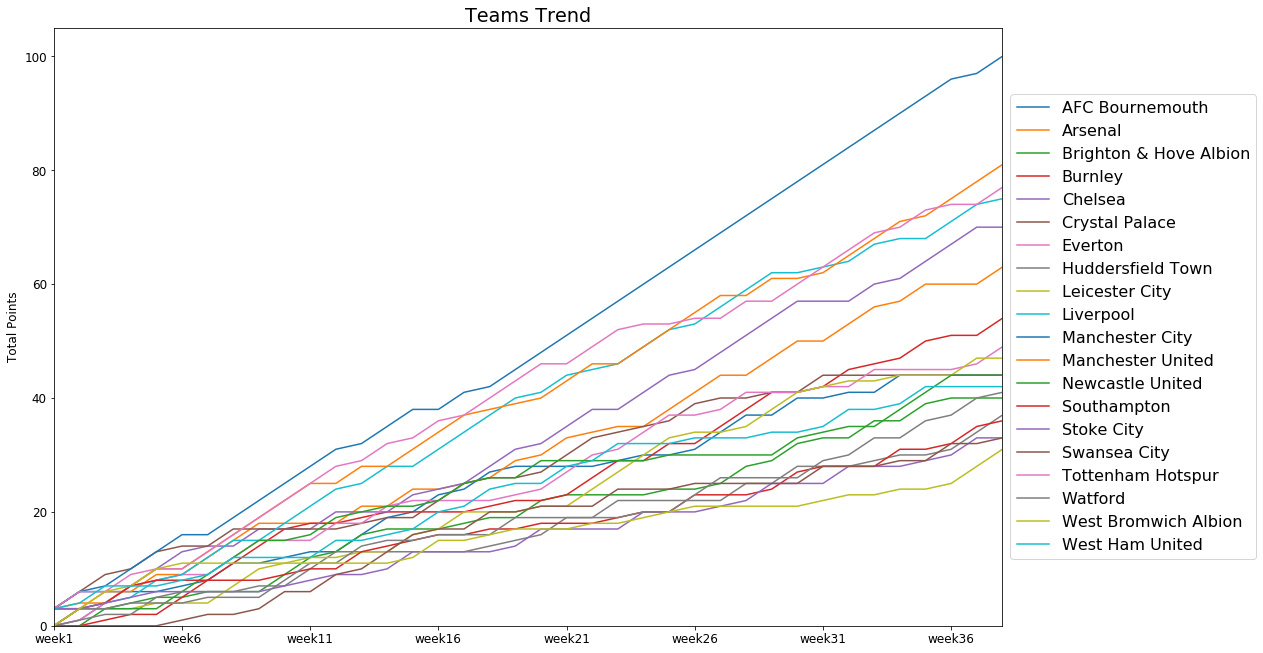

In [52]:
final_transp.cumsum().plot(figsize=(17,11))
plt.rcParams.update({'font.size': 16})

plt.ylim(0, 105)
plt.xlim(0, 37)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
plt.ylabel('Total Points')
plt.title('Teams Trend')
plt.show()

In [53]:
# function to count the number of consecutive wins or loses
def consecutive_act(arr, n):
    arr = np.array(list(arr))    # convert elements to `str`
    n_pos = np.argwhere(arr == str(n)).ravel()  # find out positions of n
    if not n_pos.size:  # if there are no three, return 0
        return 0

    full = np.arange(n_pos[0], n_pos[-1]+1)  # get the range of spread of n
    # get the indices where n` or  was flipped to something else
    diff = np.setdiff1d(full, n_pos)
    if not diff.size:     # if there are no bit flips, return the size of the full range
        return len(full)  

    # break the array into pieces wherever there's a bit flip and the result is the size of the largest chunk
    
    pos, difs = full[0], []
    for el in diff:
        difs.append(el - pos)
        pos = el + 1

    difs.append(full[-1]+1 - pos)

    # return size of the largest chunk
    res = max(difs) if max(difs) != 1 else 0

    return res
        

In [54]:
# assuming you have your data in `df`
final_dataset['concated'] = final_dataset.astype(str).apply(lambda x: ''.join(x), axis=1)
final_dataset['consecutive_win'] = final_dataset.concated.apply(lambda x: consecutive_act(x, 3))
final_dataset['consecutive_lose'] = final_dataset.concated.apply(lambda x: consecutive_act(x, 0))
final_dataset.drop(columns = ['concated'], inplace=True)

In [55]:
final_dataset.head(2)

week1  week2  week3  week4  week5  week6  week7  week8  \
teams_name                                                                
AFC Bournemouth      3      3      0      0      0      1      1      3   
Arsenal              3      0      3      0      3      0      3      3   

                 week9  week10  ...  week31  week32  week33  week34  week35  \
teams_name                      ...                                           
AFC Bournemouth      0       1  ...       0       1       0       3       0   
Arsenal              3       0  ...       0       3       3       1       3   

                 week36  week37  week38  consecutive_win  consecutive_lose  
teams_name                                                                  
AFC Bournemouth       0       0       0                2                 4  
Arsenal               0       0       3                3                 3  

[2 rows x 40 columns]

In [56]:
# top 2 highest consecutive wins
order_by_wins = final_dataset.sort_values('consecutive_win', ascending=False).index[:2]

In [57]:
# top 2 highest consecutive loses
order_by_lose = final_dataset.sort_values('consecutive_lose', ascending=False).index[:2]

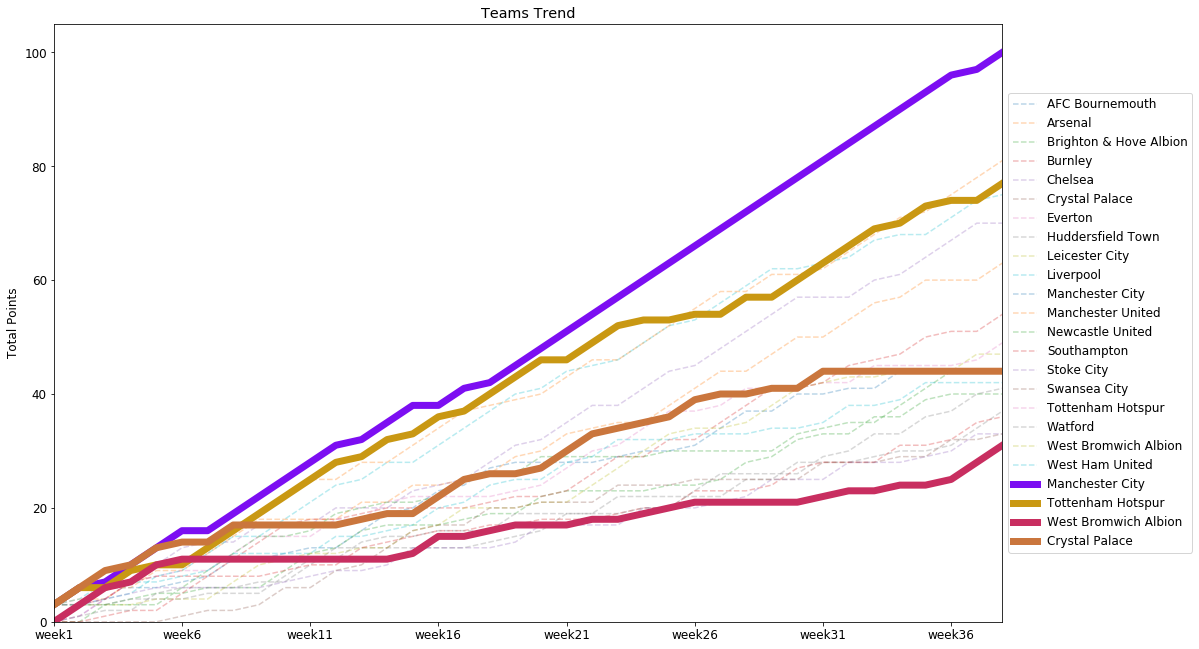

In [58]:
fig = plt.figure(figsize=(17,11))
plt.rcParams.update({'font.size': 12})

col = []
for i in range(4):
    r = lambda: random.randint(0,255)
    colr = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
    col.append(colr)

# multiple line plot
for column in final_transp:
    final_transp[column].cumsum().plot(x='index', alpha = 0.3, linestyle='--')
    
for j in range(2):
    plt.plot(final_transp[order_by_wins[j]].cumsum(), color = col[:len(order_by_wins)][j], 
             linewidth=7, alpha=1, label= order_by_wins[j])
    
for i in range(2):
    plt.plot(final_transp[order_by_lose[i]].cumsum(), color = col[-len(order_by_lose):][i], 
             linewidth=7, alpha=1, label= order_by_lose[i])

    
    

plt.ylim(0, 105)
plt.xlim(0, 37)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
plt.ylabel('Total Points')
plt.title('Teams Trend')
plt.show()

In [60]:
print('The teams with the longest winning streak are: ' + order_by_wins[0] + ' and ' + order_by_wins[1])
print('The teams with the longest losing streak are: ' + order_by_lose[0] + ' and ' + order_by_lose[1])

The teams with the longest winning streak are: Manchester City and Tottenham Hotspur
The teams with the longest losing streak are: West Bromwich Albion and Crystal Palace


# RQ2:  Is there a home-field advantage?

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize  
import matplotlib.pyplot as plt

# Import Matches

In [2]:
dataset = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/matches/matches_England.json')

In [3]:
# In order to work easily, I select only the most useful columns for this task. 
sub_dataset = dataset[['status','winner', 'label']] 

In [4]:
# Now I will extract all the information contained in the label column and rearrange it!
label = pd.DataFrame(sub_dataset['label'])

label.head(3)

label
0              Burnley - AFC Bournemouth, 1 - 2
1  Crystal Palace - West Bromwich Albion, 2 - 0
2            Huddersfield Town - Arsenal, 0 - 1

In [5]:
new_dataset = label["label"].str.split(",",n = 1, expand = True) # split the column label

In [6]:
new_dataset.columns = ("teams", "score") # rename the columns

In [7]:
new_dataset.head(3)

teams   score
0              Burnley - AFC Bournemouth   1 - 2
1  Crystal Palace - West Bromwich Albion   2 - 0
2            Huddersfield Town - Arsenal   0 - 1

In [8]:
teams = new_dataset["teams"].str.split("-",n = 1, expand = True) # split the teams column

In [9]:
# merge teams to the sub_dataset
dataset = pd.merge(sub_dataset, teams, left_index=True, right_index=True)

dataset.head(5)

status  winner                                         label  \
0  Played    1659              Burnley - AFC Bournemouth, 1 - 2   
1  Played    1628  Crystal Palace - West Bromwich Albion, 2 - 0   
2  Played    1609            Huddersfield Town - Arsenal, 0 - 1   
3  Played    1612     Liverpool - Brighton & Hove Albion, 4 - 0   
4  Played    1611            Manchester United - Watford, 1 - 0   

                    0                        1  
0            Burnley           AFC Bournemouth  
1     Crystal Palace      West Bromwich Albion  
2  Huddersfield Town                   Arsenal  
3          Liverpool    Brighton & Hove Albion  
4  Manchester United                   Watford

In [10]:
# check il all the matches had been played
dataset['status'].unique()

array(['Played'], dtype=object)

In [11]:
dataset.drop(columns = ['label','status'], inplace=True)

In [12]:
# rename columns
dataset.columns = ("winner", "home", "away")
dataset.head(2)

winner             home                   away
0    1659         Burnley         AFC Bournemouth
1    1628  Crystal Palace    West Bromwich Albion

In [13]:
# adjust the home and away strings. Because they contain extra spaces
home = []
for i in dataset['home']:
    j = " ".join(i.split())
    home.append(j)
away = []
for i in dataset['away']:
    j = " ".join(i.split())
    away.append(j)

dataset['home'] = home
dataset['away'] = away

In [14]:
dataset.head(5)

winner               home                    away
0    1659            Burnley         AFC Bournemouth
1    1628     Crystal Palace    West Bromwich Albion
2    1609  Huddersfield Town                 Arsenal
3    1612          Liverpool  Brighton & Hove Albion
4    1611  Manchester United                 Watford

Now I convert the club's names into their Id

# Import Teams

In [15]:
teams = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/teams.json')

In [16]:
teams.columns

Index(['city', 'name', 'wyId', 'officialName', 'area', 'type'], dtype='object')

Now I extract the name of the country of each club in order to focus on the premier league

In [17]:
# transform the area column into the nountry name
L = []
for i in teams['area']:
    L.append(i['name'])
teams['area'] = L

In [18]:
# extract only the teams that are in England or Wales
keep = ['England', 'Wales']
teams = teams.loc[teams['area'].isin(keep)]

In [19]:
teams.head(5)

city                    name   wyId  \
0            Newcastle upon Tyne        Newcastle United   1613   
8   Huddersfield, West Yorkshire       Huddersfield Town   1673   
19                       Swansea            Swansea City  10531   
26           Bournemouth, Dorset         AFC Bournemouth   1659   
27         Brighton, East Sussex  Brighton & Hove Albion   1651   

                 officialName     area  type  
0         Newcastle United FC  England  club  
8        Huddersfield Town FC  England  club  
19           Swansea City AFC    Wales  club  
26            AFC Bournemouth  England  club  
27  Brighton & Hove Albion FC  England  club

In [20]:
 # select only clubs from the Premier League. Delete National teams and keep clubs
teams = teams[teams.type != 'national'] 

In [21]:
teams.shape

(20, 6)

In [22]:
dataset

winner                  home                    away
0      1659               Burnley         AFC Bournemouth
1      1628        Crystal Palace    West Bromwich Albion
2      1609     Huddersfield Town                 Arsenal
3      1612             Liverpool  Brighton & Hove Albion
4      1611     Manchester United                 Watford
..      ...                   ...                     ...
375    1623               Everton              Stoke City
376       0           Southampton            Swansea City
377    1627  West Bromwich Albion         AFC Bournemouth
378       0               Watford               Liverpool
379    1609               Arsenal          Leicester City

[380 rows x 3 columns]

In [23]:
# get the team's ID 
home_Id = []
for i in dataset['home']:
    j = teams.name[teams.name == i].index.tolist()[0]
    home_Id.append(teams['wyId'][j])

In [24]:
# get the team's ID 
away_Id = []
for i in dataset['away']:
    j = teams.name[teams.name == i].index.tolist()[0]
    away_Id.append(teams['wyId'][j])


In [25]:
dataset['home'] = home_Id
dataset['away'] = away_Id

In [26]:
dataset

winner  home   away
0      1659  1646   1659
1      1628  1628   1627
2      1609  1673   1609
3      1612  1612   1651
4      1611  1611   1644
..      ...   ...    ...
375    1623  1623   1639
376       0  1619  10531
377    1627  1627   1659
378       0  1644   1612
379    1609  1609   1631

[380 rows x 3 columns]

Ramdon selection of 5 teams for the Chi Squared test

In [27]:
small_sample = dataset['home'].unique()
small_sample = np.random.choice(small_sample, 5, replace=False)
small_sample

array([ 1609,  1633,  1651,  1646, 10531])

Remove that match played among the teams we randomly selected

In [28]:
import itertools
matches_to_remove = list(itertools.permutations(small_sample, 2))


In [29]:
rows_to_remove = []
for i in matches_to_remove:
    lst_h = dataset.index[dataset['home'] == i[0]].tolist() # all postions of the first team when playing at home
    lst_a = dataset.index[dataset['away'] == i[1]].tolist() # all positions of the second team when playing away
    rows_to_remove.append(list(set(lst_h).intersection(lst_a))) # the only position that is in common correspond 
                                                                # to the match to delete


In [30]:
# Delete row with index label 'b' 
for j in rows_to_remove:
    for p in j:
        dataset = dataset.drop(p)
dataset.shape

(360, 3)

### Contingency table

In [31]:
print('contingency table of 5 random teams', "\n")

draw_h_all = 0    # total number of draw when playing at home
draw_a_all = 0    # total number of draw when playing away
win_h_all = 0    # total number of win when playing at home
lose_h_all = 0    # total number of lose when playing at home
win_a_all = 0    # total number of win when playing away
lose_a_all = 0   # total number of lose when playing away 

for team in small_sample:
    
    draw_h = 0   # number of draw when playing at home
    draw_a = 0   # number of draw when playing away
    win_h = 0    # number of win when playing at home
    lose_h = 0    # number of lose when playing at home
    win_a = 0     #number of win when playing away
    lose_a = 0   # number of lose when playing away
    
    lst_h = dataset.index[dataset['home'] == team].tolist() # get the index of the team when playing at home
    lst_a = dataset.index[dataset['away'] == team].tolist() # get the index of the team when playing at home
    
    for pos in lst_h:
        if dataset['winner'][pos] == 0:   # when there is a zero, we have a draw
            draw_h += 1
        else:
            if dataset['winner'][pos] == dataset['home'][pos]:  # when playing at home count the number of wins
                win_h += 1
            else:
                lose_h += 1
    for pos in lst_a:
        if dataset['winner'][pos] == 0:      # when there is a zero, we have a draw
            draw_a += 1
        else:
            if dataset['winner'][pos] == dataset['away'][pos]:     # when playing away count the number of wins
                win_a += 1
            else:
                lose_a += 1
                
    draw_h_all += draw_h
    draw_a_all += draw_a
    win_h_all += win_h
    lose_h_all += lose_h
    win_a_all += win_a
    lose_a_all += lose_a
    
                
                # create the contingency table
    df = pd.DataFrame({'win':[win_h, win_a, (win_h + win_a)], 
                       'draw': [draw_h, draw_a, (draw_h + draw_a)], 
                       'lose' : [lose_h, lose_a, (lose_h + lose_a)],
                      'all': [(win_h + draw_h + lose_h), (win_a + draw_a + lose_a), 
                              (win_h + draw_h + lose_h + win_a + draw_a + lose_a)]})
    df.index = ('home', 'away', 'all')
    
    j = teams.name[teams.wyId == team].index.tolist()[0]
    team_name = teams['name'][j]
    
    print('team: '+ team_name)
    print(df, "\n")
    print('***********************************', "\n")

contingency table of 5 random teams 

team: Arsenal
      win  draw  lose  all
home   11     2     2   15
away    3     3     9   15
all    14     5    11   30 

*********************************** 

team: West Ham United
      win  draw  lose  all
home    6     5     4   15
away    3     5     7   15
all     9    10    11   30 

*********************************** 

team: Brighton & Hove Albion
      win  draw  lose  all
home    4     7     4   15
away    0     5    10   15
all     4    12    14   30 

*********************************** 

team: Burnley
      win  draw  lose  all
home    6     3     6   15
away    6     6     3   15
all    12     9     9   30 

*********************************** 

team: Swansea City
      win  draw  lose  all
home    3     3     9   15
away    2     6     7   15
all     5     9    16   30 

*********************************** 



In [32]:
print('overall contingency table')

df = pd.DataFrame({'win':[win_h_all, win_a_all, (win_h_all + win_a_all)], 
                   'draw': [draw_h_all, draw_a_all, (draw_h_all + draw_a_all)], 
                   'lose' : [lose_h_all, lose_a_all, (lose_h_all + lose_a_all)],
                  'all': [(win_h_all + draw_h_all + lose_h_all), (win_a_all + draw_a_all + lose_a_all), 
                          (win_h_all + draw_h_all + lose_h_all + win_a_all + draw_a_all + lose_a_all)]})
df.index = ('home', 'away', 'all')
print(df)

overall contingency table
      win  draw  lose  all
home   30    20    25   75
away   14    25    36   75
all    44    45    61  150


In [33]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# contingency table

table = df
print(table, "\n")
print('Our NULL Hypothesis is that there is home field advantage in sport', "\n")

stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof, "\n")
print(expected, "\n")



# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)

print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat), "\n")

if abs(stat) >= critical:
    print('Dependent (reject H0)', "\n")
else:
    print('Independent (fail to reject H0)', "\n")
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p), "\n")
if p <= alpha:
    print('Dependent (reject H0)', "\n")
else:
    print('Independent (fail to reject H0)', "\n")



      win  draw  lose  all
home   30    20    25   75
away   14    25    36   75
all    44    45    61  150 

Our NULL Hypothesis is that there is home field advantage in sport 

dof=6 

[[ 22.   22.5  30.5  75. ]
 [ 22.   22.5  30.5  75. ]
 [ 44.   45.   61.  150. ]] 

probability=0.950, critical=12.592, stat=8.357 

Independent (fail to reject H0) 

significance=0.050, p=0.213 

Independent (fail to reject H0) 



# Conclusion

After our building our overall contingency table and performing our Chi Squared test. We argue that there is not a relationship between that field (home, away) and the result of the match (win, draw and lose). WE arrived to this conclusion because we fail to reject our Null Hypotesis (stating the correlation between the feild and the match's result). 

# RQ3: Which teams have the youngest coaches?

In [15]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import data

In [275]:
coaches = pd.read_json('coaches.json', encoding='utf-8')
players = pd.read_json('players.json', encoding='utf-8')
teams = pd.read_json('teams.json', encoding='utf-8')
matches_England = pd.read_json('matches_England.json', encoding='utf-8')
events_England = pd.read_json('events_England.json', encoding='utf-8')
# events_France = pd.read_json('events_France.json')
# events_Italy = pd.read_json('events_Italy.json')
# events_Germany = pd.read_json('events_Germany.json')

In [188]:
# Calculate age of all coaches.
coaches['age'] = coaches.birthDate.apply(lambda x: datetime.now().year - int(x[:4]) if x else 0)
coaches['age'] = coaches['age'].astype('int')

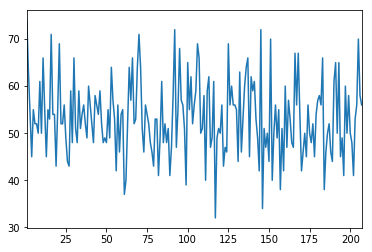

In [189]:
# Plot age distribution.
coaches['age'][coaches.age!=0].plot()

In [190]:
# Merge coaches and teams.
top10 = coaches[['age', 'currentTeamId']][(coaches.age!=0)&(coaches.currentTeamId!=0)].merge(teams[['wyId', 'name']], left_on='currentTeamId', right_on='wyId')

In [191]:
# During a season a team could have more coaches, in that case pick the younger of them.
top10 = pd.DataFrame(top10[['age','name']].groupby('name').min())

In [204]:
# Rank all the teams by the age of their coach and show the 10 teams with the youngest coaches. 
top10.sort_values(by='age').reset_index().loc[:9]

name  age
0          Hoffenheim   32
1       Werder Bremen   37
2        Hamburger SV   38
3  Saint-\u00c9tienne   39
4            Sassuolo   40
5          Villarreal   41
6             Udinese   41
7               Milan   41
8            Mainz 05   41
9             Everton   42

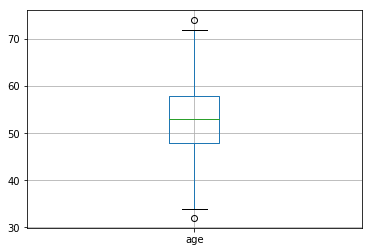

In [193]:
# Show the distirbutions of the ages of all coaches in Premier League, using a boxplot.
coaches[['age']][coaches.age!=0].boxplot()

# RQ4: Find the top 10 players with the highest ratio between completed passes and attempted passes.

In [167]:
# Build column pass_tags(only including 1801 and 1802)
def func(x):
    lst = [item['id'] for item in x if item['id'] in (1801, 1802)]
    return lst[0] if lst else None
events_England['pass_tags'] = events_England.tags.apply(lambda x: func(x))

In [168]:
# Build column count to count the number of passes
events_England['count'] = 1

In [169]:
# Calculate the total number of passes
df_count = pd.DataFrame(events_England[['eventSec', 'playerId', 'count']][events_England.eventName=='Pass'].groupby(['playerId']).sum()).reset_index()
df_count.rename(columns={'count':'total_count'}, inplace=True)

In [170]:
# Calculate the number of completed passes
df_1801 = pd.DataFrame(events_England[['playerId', 'count']][(events_England.eventName=='Pass')&(evente_England.pass_tags==1801)].groupby(['playerId']).sum()).reset_index()

In [199]:
# Calculate the ratio
top10_players = df_1801.merge(df_count, on='playerId')
top10_players['ratio'] = top10_players[['count', 'total_count']].apply(lambda x: x['count']/x['total_count'], axis=1)
top10_players.sort_values(by='ratio', ascending=False, inplace=True)

In [200]:
# Merge players to find the names of players
top10_players = top10_players[top10_players.eventSec>1e5].loc[:10,['playerId', 'ratio']]
top10_players = top10_players.merge(players[['wyId', 'firstName','lastName','middleName']], left_on='playerId', right_on='wyId')

In [203]:
top10_players[['firstName','lastName','middleName', 'ratio']].loc[:9]

firstName            lastName middleName     ratio
0                      John              Stones             0.975914
1   Gn\u00e9gn\u00e9ri Yaya          Tour\u00e9             0.948020
2                    Fabian               Delph             0.945076
3                   Vincent             Kompany             0.943206
4                   Andreas         Christensen             0.940217
5                       Per         Mertesacker             0.939914
6                      Phil               Jones             0.938505
7  Nicol\u00e1s Hern\u00e1n            Otamendi             0.937584
8             Mohamed Naser      Elsayed Elneny             0.936451
9                \u0130lkay  G\u00fcndo\u011fan             0.935556

# CRQ1: What are the time slots of the match with more goals?

In [276]:
# Build goal_tags to find all goals
def func(x):
    lst = [item['id'] for item in x if item['id'] in (101, 102)]
    return lst[0] if lst else None
events_England['goal_tags'] = events_England.tags.apply(lambda x: func(x))

In [277]:
# Note there is no extra time
events_England.matchPeriod.value_counts()

1H    323574
2H    319576
Name: matchPeriod, dtype: int64

In [279]:
# Calculate eventSet(plus 2H time)
goals = events_England[['eventSec', 'matchId', 'teamId', 'playerId', 'matchPeriod']][events_England.goal_tags.notnull()]
goals['eventSec'][goals.matchPeriod == '2H'] = goals['eventSec'][goals.matchPeriod == '2H'].apply(lambda x: x+45*60)
goals.sort_values('eventSec', inplace=True)

In [281]:
# Build 10 columns to define which time slot the goal belongs to
for i in range(10):
    goals['time_slot_%s'%i] = goals['eventSec'].apply(lambda x: 1 if 9*i <= x/60 < 9*(i+1) else 0)

## Make a barplot with the absolute frequency of goals in all the time slots.

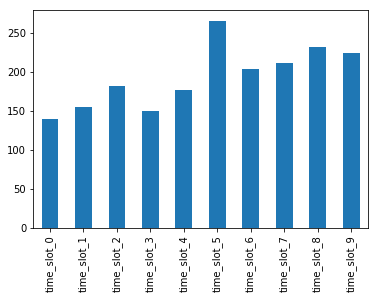

In [292]:
cols = ['time_slot_%s'%i for i in range(10)]
goals[cols].sum().plot.bar()

 ## Find the top 10 teams that score the most in the interval "81-90".

In [305]:
top10_teams = pd.DataFrame(goals[['teamId', 'time_slot_9']].groupby('teamId').sum()).reset_index()
top10_teams.sort_values('time_slot_9', ascending=False, inplace=True)
top10_teams = top10_teams.merge(teams[['wyId', 'name']], left_on='teamId', right_on='wyId')

In [309]:
top10_teams[['name', 'time_slot_9']].loc[:9]

name  time_slot_9
0                 Arsenal           16
1                 Watford           16
2         Manchester City           15
3         West Ham United           15
4                 Chelsea           14
5          Crystal Palace           13
6                 Everton           12
7  Brighton & Hove Albion           12
8            Swansea City           12
9               Liverpool           11

In [314]:
cols.append('playerId')

In [320]:
good_players = pd.DataFrame(goals[cols].groupby('playerId').max()).reset_index()

In [329]:
good_players = good_players[(good_players.time_slot_0==1)&(good_players.time_slot_1==1)&(good_players.time_slot_2==1)&(good_players.time_slot_3==1)&(good_players.time_slot_4==1)&(good_players.time_slot_5==1)&(good_players.time_slot_6==1)&(good_players.time_slot_7==1)&(good_players.time_slot_8==1)&(good_players.time_slot_9==1)]

In [332]:
good_players = good_players.merge(players[['wyId', 'firstName','lastName','middleName']], left_on='playerId', right_on='wyId')

In [333]:
good_players[['firstName','lastName','middleName']]

firstName                 lastName middleName
0        Adri\u00e1n  San Miguel del Castillo           
1        \u0141ukasz           Fabia\u0144ski           
2               Petr                \u010cech           
3              David          de Gea Quintana           
4               Jack                  Butland           
5           Heurelho           da Silva Gomes           
6                Joe                     Hart           
7                Ben                   Foster           
8        Juli\u00e1n                  Speroni           
9             Wayne                 Hennessey           
10            Kasper               Schmeichel           
11             Harry                     Kane           
12             Asmir             Begovi\u0107           
13            Jordan                 Pickford           
14  Raheem Shaquille                 Sterling           
15             Jamie                    Vardy           
16              Hugo                   Lloris           
17             Jonas               L\u00f6ssl           
18            Mathew                     Ryan           
19           Ederson        Santana de Moraes           
20          Mohamed               Salah Ghaly

# RQ5 - Does being a tall player mean winning more air duels?

In [26]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.io.json import json_normalize #package for flattening json in pandas df


# Import data

In [10]:
#load event_Engalnd.json file and import it in a pandas dataframe called 'events'
with open('/Users/digitalfirst/Desktop/homework_dataFrame/events/events_England.json') as f:
    d = json.load(f)

events = json_normalize(data=d, record_path='tags', 
                            meta=['subEventName', 'playerId'])


#load players.json file and import it in a pandas dataframe called 'players'. 
with open('/Users/digitalfirst/Desktop/homework_dataFrame/players.json') as f:
    d = json.load(f)
players = json_normalize(d)
#get only height and wyId for every player
players=players[['height','wyId','shortName']]



We have choosen to consider air duel accurate (tag=1801) as air duel won, and not accurate air duel (tag=1802) as air duel lost

In [27]:
#filter dataframe to get only air duel
air_duel=events.loc[events['subEventName'] == "Air duel"]

#filter only air duel with tag id that is equal to 1801 or 1802. 
air_duel=air_duel.loc[(air_duel['id'] == 1801) | (air_duel['id'] == 1802)]


We have choosen a threshold of minimum air duels attempted, equal to 10

In [28]:
#merge players and air_duel datafram to get a dataframe with evry air duel of every player
df_merge = pd.merge(air_duel,players,left_on='playerId', right_on='wyId')
df_merge=df_merge[['height','id','wyId','shortName']]

#with groupby i count for every players how many air duel has attempted
df_merge=pd.DataFrame({'count' : df_merge.groupby(['height','wyId','shortName']).wyId.count()}).reset_index()

#set a threshold (=10) of minimum air duels attempted for every players
indexNames = df_merge[ df_merge['count'] < 10 ].index
df_merge.drop(indexNames , inplace=True)


#merge air_duel with df_merge. In this way i have every tag id for every air duel attempted from the respective players (with minmum 10 air duels attempted)
#every players is identified by his height
airDuel_threshold = pd.merge(air_duel,df_merge,left_on='playerId', right_on='wyId')
airDuel_threshold = airDuel_threshold[['height','id','shortName']]



In [29]:
#put all air duel accurate in airduel_won 
airDuel_won=airDuel_threshold.loc[airDuel_threshold['id'] == 1801]

#put all air duel not accurate in airduel_won 
airDuel_lose=airDuel_threshold.loc[airDuel_threshold['id'] == 1802]



We got the amnount of accurate air duel for evry height

In [30]:
#with groupby i count occurences of every height in dataframe airduel_won (i.e. where air duel is accurate). 'df_total_win' contains every height with rispective amount of air duel won
df_total_win=pd.DataFrame({'count' : airDuel_won.groupby(['height','id']).height.count()}).reset_index()
df_total_win=df_total_win.drop(['id'], axis=1).rename(columns={"count": "count_accurate"})
df_total_win.head(6)

height  count_accurate
0     163              16
1     165              13
2     167              17
3     168              71
4     169              31
5     170             124

We got the amnount of not accurate air duel for evry height

In [31]:

#with groupby i count occurences of every height in dataframe airduel_lose (i.e. where air duel is not accurate). 'df_total_lose' countanis every height qith rispective amount of air duel lose
df_total_lose = pd.DataFrame({'count' : airDuel_lose.groupby(['height','id']).height.count()}).reset_index()
df_total_lose=df_total_lose.drop(['id'], axis=1).rename(columns={"count": "count_not_accurate"})
df_total_lose.head(6)

height  count_not_accurate
0     163                  25
1     165                  22
2     167                  71
3     168                  92
4     169                  74
5     170                 129

For every height we got the amount of accurate air duel, not accurate air duel, total air duel and ratio between accurate air duel and the total amount of air duel

In [32]:
#merge df_total_lose and df_total_win. In this way we have a single dataframe 'height_passes' with amount of air duel won/lose for every height
height_passes = pd.merge(df_total_lose,df_total_win,left_on='height', right_on='height')

#from 'height_passes' i caluclate the total air duel for every height and put these results in a new column 'total_air_duel'
height_passes["total_air_duel"] = height_passes["count_not_accurate"]+height_passes["count_accurate"]

#I calculate the ratio in % bettween air duel won and total air duel for every height
height_passes["ratio_air_duel"] = height_passes["count_accurate"]/height_passes["total_air_duel"]
height_passes["ratio_air_duel"] = height_passes["ratio_air_duel"] *100

height_passes.head(15)


height  count_not_accurate  count_accurate  total_air_duel  ratio_air_duel
0      163                  25              16              41       39.024390
1      165                  22              13              35       37.142857
2      167                  71              17              88       19.318182
3      168                  92              71             163       43.558282
4      169                  74              31             105       29.523810
5      170                 129             124             253       49.011858
6      171                 102              45             147       30.612245
7      172                 151              99             250       39.600000
8      173                 352             267             619       43.134087
9      174                 289             272             561       48.484848
10     175                 577             425            1002       42.415170
11     176                 499             518            1017       50.934120
12     177                 226             213             439       48.519362
13     178                 992            1051            2043       51.443955
14     179                 514             538            1052       51.140684

We have drawn a Scatterplot thtat represents the ratio between the amount of air duel won and the amount of air total attempted from every different height. We have choosen to color with 5 different colors the different points on the scatterplot (1 color for every range of 15 cm, as written in legend)  

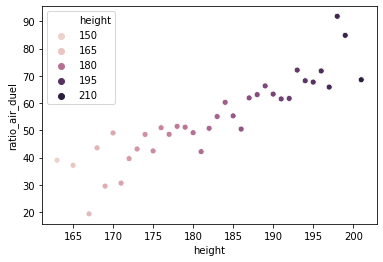

In [49]:
#draw scatterplot with different colo evry 15 cm
scatterPlot = sns.scatterplot(x="height", y="ratio_air_duel", hue="height", data=height_passes)


# RQ6: Free your mind! 

## We have choosen to study the different age in all five main Europe championships (premier league- liga - serie a - bundesliga - ligue 1). This study has been done for all players and for different role. The results were shown with differents barplot.



In [58]:
import json 
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.io.json import json_normalize #package for flattening json in pandas df



# Import data

In [59]:
#load teams.json in df_teams dataframe
with open('/Users/digitalfirst/Desktop/homework_dataFrame/teams.json') as f:
    teams = json.load(f)
df_teams = json_normalize(teams)

#load players.json on a 'palers' dataframe
with open('/Users/digitalfirst/Desktop/homework_dataFrame/players.json') as f:
    d = json.load(f)
players = json_normalize(d)

In [60]:
#filter for club teams 
df_teams_club=df_teams.loc[(df_teams["type"] == "club")]
#filter for different nation and put teams for every nation
df_teams_england=df_teams_club.loc[(df_teams_club["area.name"] == "England")]
df_teams_italy=df_teams_club.loc[(df_teams_club["area.name"] == "Italy")]
df_teams_spain=df_teams_club.loc[(df_teams_club["area.name"] == "Spain")]
df_teams_germany=df_teams_club.loc[(df_teams_club["area.name"] == "Germany")]
df_teams_france=df_teams_club.loc[(df_teams_club["area.name"] == "France")]

df_teams_italy.head(6)

area.alpha2code area.alpha3code area.id area.name      city      name  \
18              IT             ITA     380     Italy   Ferrara      SPAL   
34              IT             ITA     380     Italy    Milano     Milan   
36              IT             ITA     380     Italy    Torino  Juventus   
37              IT             ITA     380     Italy      Roma      Roma   
38              IT             ITA     380     Italy  Sassuolo  Sassuolo   
47              IT             ITA     380     Italy   Bologna   Bologna   

                                   officialName  type  wyId  
18  Societ\u00e0 Polisportiva Ars et Labor 2013  club  3204  
34                                     AC Milan  club  3157  
36                                  Juventus FC  club  3159  
37                                      AS Roma  club  3158  
38                           US Sassuolo Calcio  club  3315  
47                              Bologna FC 1909  club  3166

We used this function to calculate age from year of birth

In [61]:
#this a function that calucate age from a born year that we have in input
def calculate_age(born):
    today = date.today()
    year, month, day = [int(f) for f in born.split('-')]
    return today.year - year - ((today.month, today.day) < (month, day))

In [62]:


#calculate age for every players and put it in a new column in a new row
players = players[['currentTeamId','wyId','role.name','shortName', 'birthDate']]
players["age"] = players.apply(lambda x: calculate_age(x['birthDate']), axis=1)

players.head(6)



currentTeamId    wyId   role.name       shortName   birthDate  age
0          4502   32777  Goalkeeper        H. Tekin  1989-06-17   30
1          3775  393228    Defender         M. Sarr  1999-01-23   20
2          3772  393230  Goalkeeper     O. Mandanda  1998-10-26   21
3           683   32793  Midfielder      A. N'Diaye  1990-03-06   29
4          2975  393247    Defender  I. Konat\u00e9  1999-05-25   20
5           676      33  Goalkeeper    J. Cillessen  1989-04-22   30

In [63]:
#filter data on players for differents role (goalkeepers, defedner, mdifielder, forward)
goalkeepers=players.loc[players['role.name'] == "Goalkeeper"]
defender=players.loc[players['role.name'] == "Defender"]
midfielder=players.loc[players['role.name'] == "Midfielder"]
forward=players.loc[players['role.name'] == "Forward"]

We calculated average age for every championship

In [64]:
mean=[]
meand_gk=[]
mean_defender=[]
mean_midfieldr=[]
mean_forward=[]
championship= ["Premier league", "Liga", "Serie A", "Bundesliga","Ligue 1"]


df_merge = pd.merge(players,df_teams_england,left_on='currentTeamId', right_on='wyId')
Mean_age_england = df_merge["age"].mean()
mean.append(Mean_age_england)

df_merge = pd.merge(players,df_teams_spain,left_on='currentTeamId', right_on='wyId')
Mean_age_spain = df_merge["age"].mean()
mean.append(Mean_age_spain)

df_merge = pd.merge(players,df_teams_italy,left_on='currentTeamId', right_on='wyId')
Mean_age_italy = df_merge["age"].mean()
mean.append(Mean_age_italy)

df_merge = pd.merge(players,df_teams_germany,left_on='currentTeamId', right_on='wyId')
Mean_age_germany = df_merge["age"].mean()
mean.append(Mean_age_germany)

df_merge = pd.merge(players,df_teams_france,left_on='currentTeamId', right_on='wyId')
Mean_age_france = df_merge["age"].mean()
mean.append(Mean_age_france)





We calculated average age for goalkeepers role

In [65]:
df_merge_gk = pd.merge(goalkeepers,df_teams_england,left_on='currentTeamId', right_on='wyId')
Mean_age_england_gk = df_merge_gk["age"].mean()
meand_gk.append(Mean_age_england_gk)

df_merge_gk = pd.merge(goalkeepers,df_teams_spain,left_on='currentTeamId', right_on='wyId')
Mean_age_spain_gk = df_merge_gk["age"].mean()
meand_gk.append(Mean_age_spain_gk)

df_merge_gk = pd.merge(goalkeepers,df_teams_italy,left_on='currentTeamId', right_on='wyId')
Mean_age_italy_gk = df_merge_gk["age"].mean()
meand_gk.append(Mean_age_italy_gk)

df_merge_gk = pd.merge(goalkeepers,df_teams_germany,left_on='currentTeamId', right_on='wyId')
Mean_age_germany_gk = df_merge_gk["age"].mean()
meand_gk.append(Mean_age_germany_gk)

df_merge_gk = pd.merge(goalkeepers,df_teams_france,left_on='currentTeamId', right_on='wyId')
Mean_age_france_gk = df_merge_gk["age"].mean()
meand_gk.append(Mean_age_france_gk)







We calculated average age for defender role

In [66]:

df_merge_defender = pd.merge(defender,df_teams_england,left_on='currentTeamId', right_on='wyId')
Mean_age_england_defender = df_merge_defender["age"].mean()
mean_defender.append(Mean_age_england_defender)

df_merge_defender = pd.merge(defender,df_teams_spain,left_on='currentTeamId', right_on='wyId')
Mean_age_spain_defender = df_merge_defender["age"].mean()
mean_defender.append(Mean_age_spain_defender)

df_merge_defender = pd.merge(defender,df_teams_italy,left_on='currentTeamId', right_on='wyId')
Mean_age_italy_defender = df_merge_defender["age"].mean()
mean_defender.append(Mean_age_italy_defender)

df_merge_defender = pd.merge(defender,df_teams_germany,left_on='currentTeamId', right_on='wyId')
Mean_age_germany_defender = df_merge_defender["age"].mean()
mean_defender.append(Mean_age_germany_defender)

df_merge_defender = pd.merge(defender,df_teams_france,left_on='currentTeamId', right_on='wyId')
Mean_age_france_defender = df_merge_defender["age"].mean()
mean_defender.append(Mean_age_france_defender)







We calculated average age for midifielder role

In [67]:
df_merge_midfielder = pd.merge(midfielder,df_teams_england,left_on='currentTeamId', right_on='wyId')
Mean_age_england_midfielder = df_merge_midfielder["age"].mean()
mean_midfieldr.append(Mean_age_england_midfielder)

df_merge_midfielder = pd.merge(midfielder,df_teams_spain,left_on='currentTeamId', right_on='wyId')
Mean_age_spain_midfielder = df_merge_midfielder["age"].mean()
mean_midfieldr.append(Mean_age_spain_midfielder)

df_merge_midfielder = pd.merge(midfielder,df_teams_italy,left_on='currentTeamId', right_on='wyId')
Mean_age_italy_midfielder = df_merge_midfielder["age"].mean()
mean_midfieldr.append(Mean_age_italy_midfielder)

df_merge_midfielder = pd.merge(midfielder,df_teams_germany,left_on='currentTeamId', right_on='wyId')
Mean_age_germany_midfielder = df_merge_midfielder["age"].mean()
mean_midfieldr.append(Mean_age_germany_midfielder)

df_merge_midfielder = pd.merge(midfielder,df_teams_france,left_on='currentTeamId', right_on='wyId')
Mean_age_france_midfielder = df_merge_midfielder["age"].mean()
mean_midfieldr.append(Mean_age_france_midfielder)



We calculated average age for forward role

In [68]:
df_merge_forward = pd.merge(forward,df_teams_england,left_on='currentTeamId', right_on='wyId')
Mean_age_england_forward = df_merge_forward["age"].mean()
mean_forward.append(Mean_age_england_forward)

df_merge_forward = pd.merge(forward,df_teams_spain,left_on='currentTeamId', right_on='wyId')
Mean_age_spain_forward = df_merge_forward["age"].mean()
mean_forward.append(Mean_age_spain_forward)


df_merge_forward = pd.merge(forward,df_teams_italy,left_on='currentTeamId', right_on='wyId')
Mean_age_italy_forward = df_merge_forward["age"].mean()
mean_forward.append(Mean_age_italy_forward)

df_merge_forward = pd.merge(forward,df_teams_germany,left_on='currentTeamId', right_on='wyId')
Mean_age_germany_forward = df_merge_forward["age"].mean()
mean_forward.append(Mean_age_germany_forward)

df_merge_forward = pd.merge(forward,df_teams_france,left_on='currentTeamId', right_on='wyId')
Mean_age_england_forward = df_merge_forward["age"].mean()
mean_forward.append(Mean_age_england_forward)

In the following figre we have shown a bar plot that shows the difference between average age about all 5 diffrent championship in Europe that we have considered.

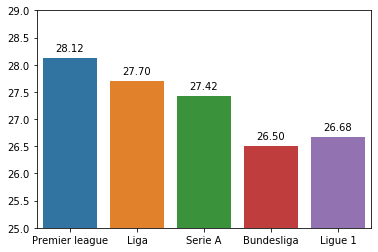

In [69]:
#total mean
ax = sns.barplot(x=championship, y=mean)
ax.set(ylim=(25, 29))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In the following figre we have shown a bar plot that shows the difference between average age for goalkeepers about all 5 diffrent championship in Europe that we have considered.

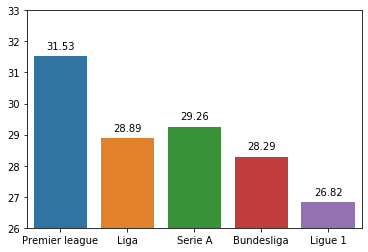

In [70]:
#mean by gk
ax = sns.barplot(x=championship, y=meand_gk)
ax.set(ylim=(26, 33))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In the following figre we have shown a bar plot that shows the difference between average age for defenders about all 5 diffrent championship in Europe that we have considered.

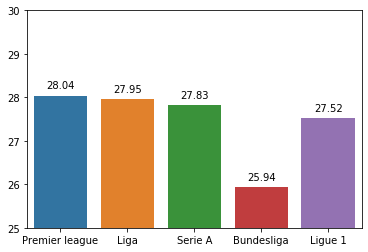

In [71]:
#mean by defender
ax = sns.barplot(x=championship, y=mean_defender)
ax.set(ylim=(25, 30))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In the following figre we have shown a bar plot that shows the difference between average age for midfielders about all 5 diffrent championship in Europe that we have considered.

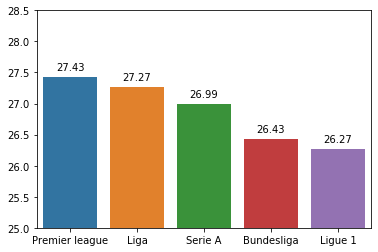

In [72]:
#mean by midfielder
ax = sns.barplot(x=championship, y=mean_midfieldr)
ax.set(ylim=(25, 28.5))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In the following figre we have shown a bar plot that shows the difference between average age for forwards about all 5 different championship in Europe that we have considered.

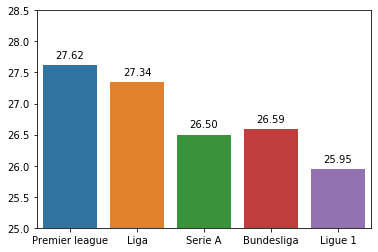

In [73]:
#mean by forward
ax = sns.barplot(x=championship, y=mean_forward)
ax.set(ylim=(25, 28.5))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



# CRQ2: Visualize movements and passes on the pitch! 

## Cristiano Ronaldo vs Messi

### Import libraries

In [40]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import datasets

In [2]:
event = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/events/events_Spain.json')

In [3]:
event.head(3)

eventId subEventName            tags  playerId  \
0        8  Simple pass  [{'id': 1801}]      3542   
1        8  Simple pass  [{'id': 1801}]    274435   
2        8  Simple pass  [{'id': 1801}]    364860   

                                  positions  matchId eventName  teamId  \
0  [{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]  2565548      Pass     682   
1  [{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]  2565548      Pass     682   
2  [{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]  2565548      Pass     682   

  matchPeriod  eventSec subEventId         id  
0          1H  2.994582         85  180864419  
1          1H  3.137020         85  180864418  
2          1H  6.709668         85  180864420

In [4]:
players = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/players.json')

In [5]:
match = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/matches/matches_Spain.json')

In [6]:
# match details
event_name = "Barcelona - Real Madrid, 2 - 2" 

### Get the positions

In [7]:
# A function that takes as input the name of a player and the event name
# and returns two lists: x_pos and y_pos. corresponding to the players coordinates during 
# sub_events during the match

def infos(atlet, event_name):
    x_pos = []
    y_pos = []
    id_match = 0
    id_match = match.loc[match['label'] == event_name]['wyId'] # reteive the match Id
    Id=0
    event_name_to_drop = ['Foul','Offside','Others on the ball']# events to delete.We are not interrested in
    
    whole_events = event.loc[event['matchId'] == int(id_match)] # all the events during the match

    Id = players.loc[players['lastName'] == atlet]['wyId']  # player's Id
    
    
    eventt = whole_events.loc[whole_events['playerId'] == int(Id)]  # from the whole events we select only 
                                                                        # those related to our player
    eventt = eventt[~eventt['eventName'].isin(event_name_to_drop)] # delete events we are not interrested in
    
    pos = pd.DataFrame(eventt['positions']) # the column containing all the events we are interrested in
    
    for i in pos['positions']:         # [{'y': 2, 'x':3}, {'y': 20, 'x':3}] 
            x_pos.append(i[0]['x']*1.04)     # I collect the x in the list X_pos and y in the list Y_pos
            #x_pos.append(i[1]['x'])
            y_pos.append(i[0]['y']*0.68)
            #y_pos.append(i[1]['y'])
            
    return(x_pos, y_pos)

    # "Messi Cuccittini"
    # "Cristiano Ronaldo"


In [8]:
# Messi's coordinates
messi_pos = infos("Messi Cuccittini", event_name)
len(messi_pos[0]) # To see the number of events Messi partecipated in

92

In [9]:
# Ronaldo's coordinates
ronaldo_pos = infos("dos Santos Aveiro", event_name) # cristino ronaldo's real name
len(ronaldo_pos[0]) # To see the number of events Ronaldo partecipated in

37

### Draw the pitch

This script I found it online and I modified it. here is the website where I found the script
http://petermckeever.com/2019/01/plotting-xy-football-data-in-python/  </br>


#####   zorder explaination  (usefull to understand the script)


The default drawing order for axes is patches, lines, text.  This
order is determined by the zorder attribute.  The following defaults
are set </br>

| Artist                  | Z-order |
|-------------------------|---------|
| Patch / PatchCollection | 1       |
| Line2D / LineCollection | 2       |
| Text                    | 3       |

You can change the order for individual artists by setting the zorder.  Any
individual plot() call can set a value for the zorder of that particular item.</br>

In the fist subplot below, the lines are drawn above the patch
collection from the scatter, which is the default.</br>

In the subplot below, the order is reversed. </br>

The second figure shows how to control the zorder of individual lines.</br>



In [15]:
from matplotlib.patches import Arc  
def draw_pitch(pitch, line):
    
 
    line = line # color of the lines
    pitch = pitch # color of the pitch
    
    # setting the plot size and correct orientation

    fig,ax = plt.subplots(figsize=(20,15))
    plt.xlim(-1,105)
    plt.ylim(-1,69)
    ax.axis('off') # this hides the x and y ticks

    # side and goal lines #
    ly1 = [0,0,68,68,0]
    lx1 = [0,104,104,0,0]

    plt.plot(lx1,ly1,color=line,zorder=5)


    # boxes, 6 yard box and goals

        #outer boxes#
    ly2 = [13.84,13.84,54.16,54.16] 
    lx2 = [104,87.5,87.5,104]
    plt.plot(lx2,ly2,color=line,zorder=5)

    ly3 = [13.84,13.84,54.16,54.16] 
    lx3 = [0,16.5,16.5,0]
    plt.plot(lx3,ly3,color=line,zorder=5)

        #goals#
    ly4 = [30.34,30.34,37.66,37.66]
    lx4 = [104,104.2,104.2,104]
    plt.plot(lx4,ly4,color=line,zorder=5)

    ly5 = [30.34,30.34,37.66,37.66]
    lx5 = [0,-0.2,-0.2,0]
    plt.plot(lx5,ly5,color=line,zorder=5)


       #6 yard boxes#
    ly6 = [24.84,24.84,43.16,43.16]
    lx6 = [104,99.5,99.5,104]
    plt.plot(lx6,ly6,color=line,zorder=5)

    ly7 = [24.84,24.84,43.16,43.16]
    lx7 = [0,4.5,4.5,0]
    plt.plot(lx7,ly7,color=line,zorder=5)

    #Halfway line, penalty spots, and kickoff spot
    ly8 = [0,68] 
    lx8 = [52,52]
    plt.plot(lx8,ly8,color=line,zorder=5)


    plt.scatter(93,34,color=line,zorder=5)
    plt.scatter(11,34,color=line,zorder=5)
    plt.scatter(52,34,color=line,zorder=5)

    # circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
    # circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
    circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

    #Prepare Arcs
    leftArc = Arc((93.9,34),height=18.30,ls='solid',width=25.3,color=line, fill=False, 
                   zorder=2,alpha=1,angle=0,theta1=130,theta2=230)
    rightArc = Arc((10.1,34),height=18.30,ls='solid',width=25.3,color=line, fill=False, 
                   zorder=2,alpha=1,angle=180,theta1=130,theta2=230)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    ## Rectangles in boxes
    rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
    rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

    ## Pitch rectangle
    rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

    ax.add_artist(rec3)
    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    ax.add_artist(rec1)
    ax.add_artist(rec2)
    ax.add_artist(circle3)
    # plt.gca().invert_yaxis() #############

        
# draw_pitch("#195905","#faf0e6","h","full")

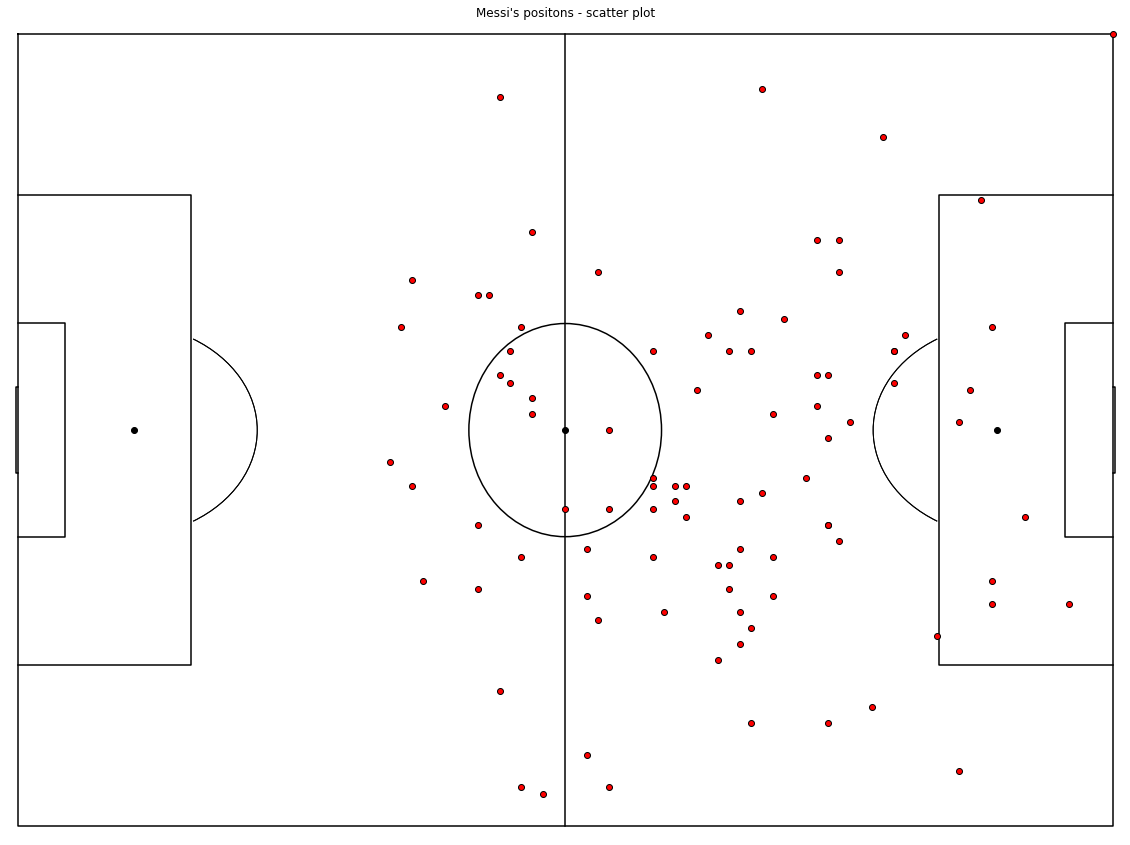

In [36]:
draw_pitch("#ffffff","#000000")
plt.scatter(messi_pos[0],messi_pos[1],marker='o',color='red',edgecolors="black", zorder=30)
plt.title("Messi's positons - scatter plot")
plt.show()

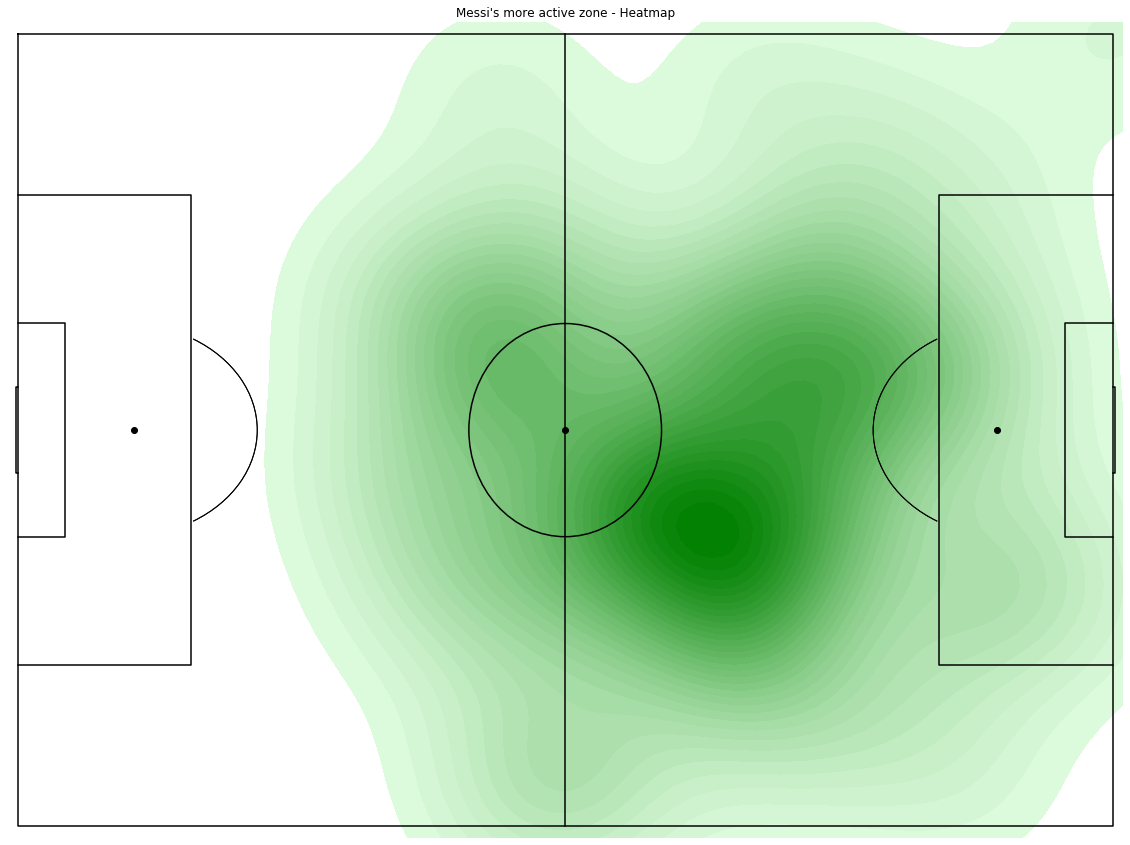

In [41]:
draw_pitch("#ffffff","#000000")
sns.kdeplot(messi_pos[0],messi_pos[1], shade = "True", color = "green", n_levels = 40,zorder=2, shade_lowest=False)
plt.title("Messi's more active zone - Heatmap")
plt.show()

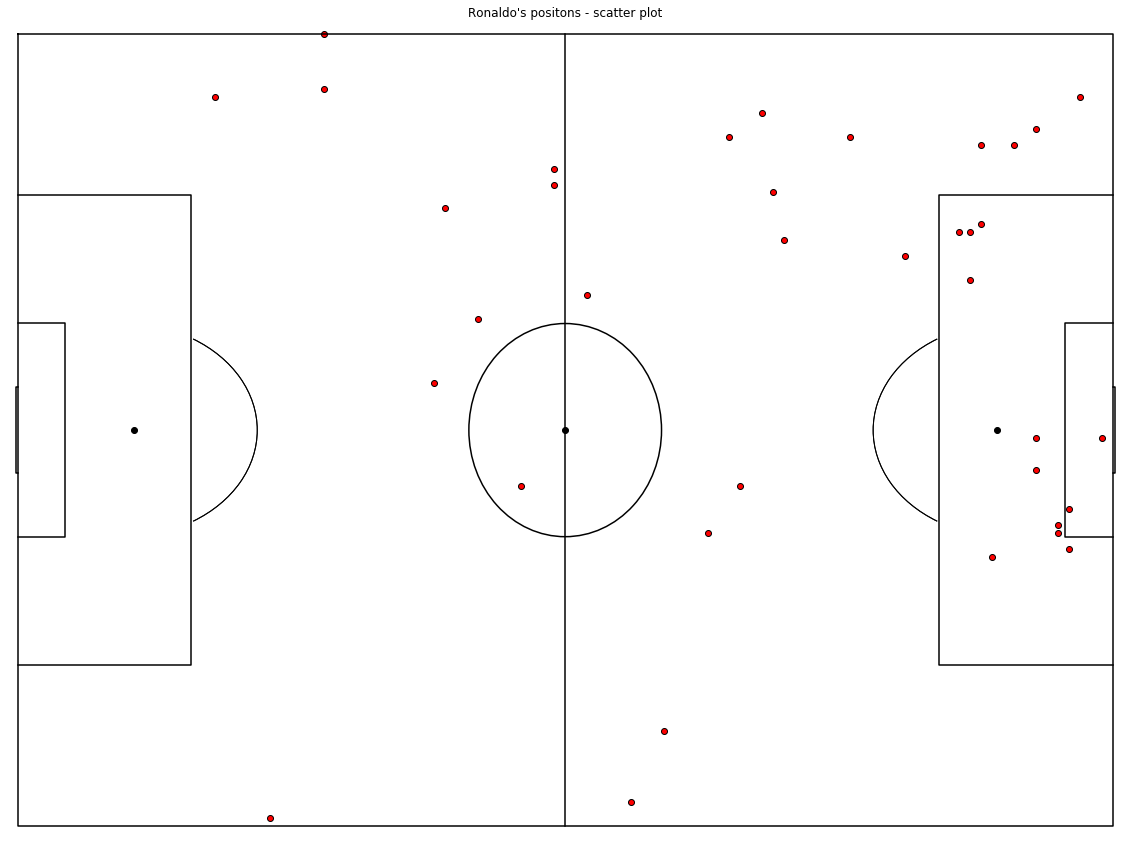

In [43]:
draw_pitch("#ffffff","#000000")
plt.scatter(ronaldo_pos[0],ronaldo_pos[1],marker='o',color='red',edgecolors="black", zorder=2)
plt.title("Ronaldo's positons - scatter plot")
plt.show()

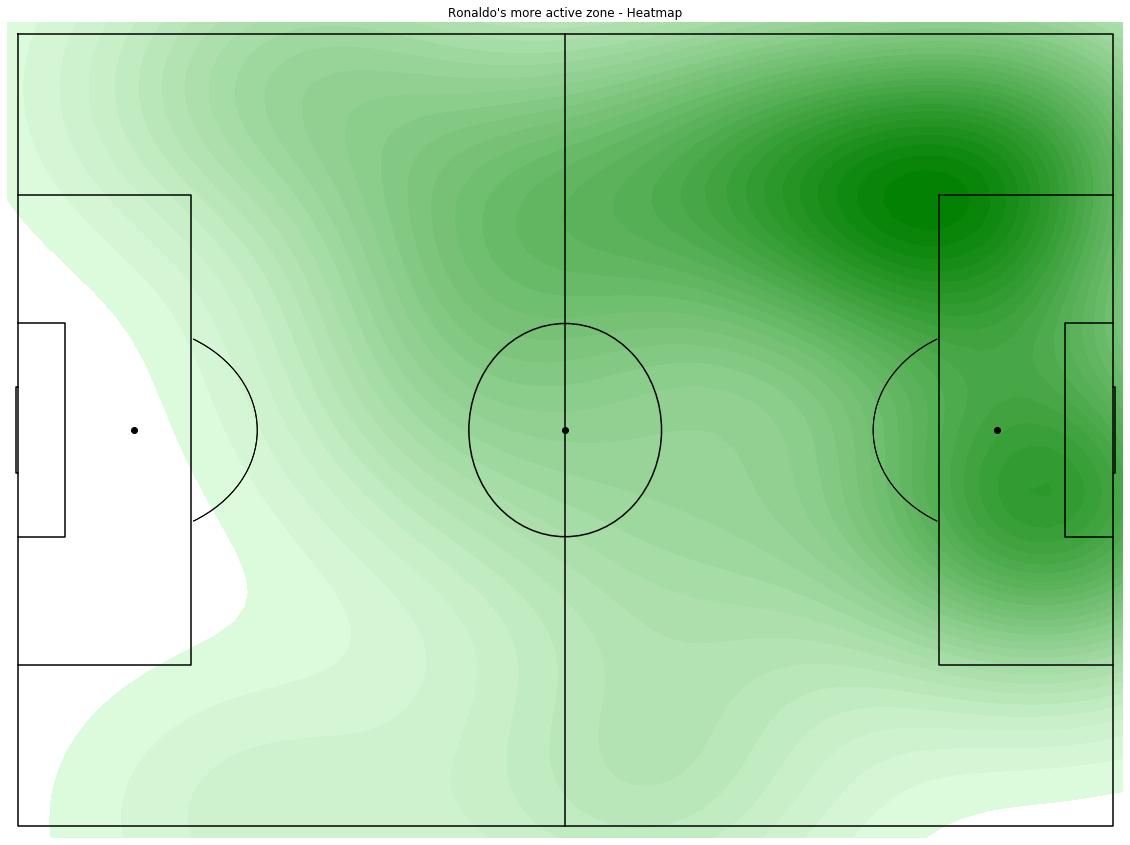

In [44]:
draw_pitch("#ffffff","#000000")
sns.kdeplot(ronaldo_pos[0],ronaldo_pos[1], shade = "True", color = "green", n_levels = 40,zorder=2, shade_lowest=False)
plt.title("Ronaldo's more active zone - Heatmap")
plt.show()

### Conclusion

Here are some few consideration about the positions of Cristiano Ronaldo and Lionel Messi during the match
Barcelona - Real Madrid played on the 6 May 2018.</br>

The first thing to notice is the difference in the number of events (passes, shoots, duels and free kicks).
Messi had participated in 92 events while Ronaldo had particpated only in 37 events. </br>

Moreover, twe found a huge difference in the positions and areas covered by this two players during this match.
Messi move around the right half of the pitch close to the center. From the heatmap it's evident he did'nt covered all the area covered by Ronaldo. Ronaldo Move not only arround the center but also near the penalty 
and goal area fo the right half of the pitch. </br>

The differences in the number of events and the difference in the area covered, suggest that Ronaldo, althought he participated in lest event, covered more space so he move a lot rispect to Messi that covered
less space but partecipated in more events. 


# Miralem Pjanic vs Jorginho

In [1]:
import json 
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.patches as pt 
from pandas.io.json import json_normalize #package for flattening json in pandas df




This following function allows us to draw a footbal field

In [3]:

def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = pt.Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = pt.Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = pt.Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = pt.ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = pt.Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = pt.Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = pt.Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = pt.Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

# Load data

In [4]:
#open matches_Italy.json in a dataframe and filter with match: Juventus-Napoli 0-1

with open('/Users/digitalfirst/Desktop/homework_dataFrame/matches/matches_Italy.json') as f:
    teams = json.load(f)
df_teams = json_normalize(teams)

match=df_teams.loc[df_teams['label']=="Juventus - Napoli, 0 - 1"]

#Get match Id about "Juventus - Napoli, 0 - 1"
match_Id=match['wyId']




In [5]:
#open events_Italy.json in a dataframe and filtered data only for pass event. We get only some atttributes

with open('/Users/digitalfirst/Desktop/homework_dataFrame/events/events_Italy.json') as f:
    d = json.load(f)

df_events = json_normalize(data=d, record_path=['positions'],
                            meta=['subEventName', 'eventName','playerId','eventSec','matchId',"subEventId"])
df_events = df_events.loc[(df_events['eventName']=='Pass')]

In [6]:

#get id for every passes and merge it with last dataframe. Now we have every pass with tags that say us the status of respective event
df_events_tags = json_normalize(data=d, record_path=['tags'],
                            meta=['eventName','eventSec'])
df_events_tags = df_events_tags.loc[(df_events_tags['eventName']=='Pass')]
df_events_tags=df_events_tags[['id','eventSec']]



In [7]:
#open players.json and put data about Jorginho and pjanic in two different dataframes

with open('/Users/digitalfirst/Desktop/homework_dataFrame/players.json') as f:
    d = json.load(f)
players = json_normalize(d)
jorginho=players.loc[players['shortName']=="Jorginho"]
pjanic=players.loc[players['firstName']=="Miralem"]


We got all passes of the match and we've put them in 'allPasses' dataframe. Every dataframe that we show contains passes that are organized in the following way:
* Every pass is identified from two rows that have the same 'eventSpec'
* We have sorted dataframe to get an order list of passes. 
* For every pass, the first row stay for the pass that has a start postion in 'x' and 'y' attributes and the second row stay for the pass that has a final position in 'x' and 'y' attributes

In [8]:
allPasses = pd.merge(match,df_events,left_on='wyId', right_on='matchId')
allPasses=allPasses[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label', "subEventId"]]
allPasses.head()

subEventName eventName  playerId  eventSec  matchId   x   y  \
0  Simple pass      Pass     21385  1.265726  2576295  50  50   
1  Simple pass      Pass     21385  1.265726  2576295  38  53   
2  Simple pass      Pass      3300  2.087491  2576295  38  53   
3  Simple pass      Pass      3300  2.087491  2576295  38  52   
4    High pass      Pass     25726  3.184110  2576295  38  52   

                      label subEventId  
0  Juventus - Napoli, 0 - 1         85  
1  Juventus - Napoli, 0 - 1         85  
2  Juventus - Napoli, 0 - 1         85  
3  Juventus - Napoli, 0 - 1         85  
4  Juventus - Napoli, 0 - 1         83

In [9]:
#merge pjanic dataframe with all passes dataframe and get from it only some attributes
allPasses_pjanic = pd.merge(allPasses,pjanic,left_on='playerId', right_on='wyId')
allPasses_pjanic=allPasses_pjanic[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label','shortName']]

#sort both dataframes about index. in this way we have a list of event for jorginho and pjanic. for every event we have tow rows, the first that have the coordinates that indicate the started position of the event, and the second row stay for the final position of respective event.
allPasses_pjanic=allPasses_pjanic.sort_index()

allPasses_pjanic.head(10)

subEventName eventName  playerId    eventSec  matchId   x   y  \
0  Simple pass      Pass     20443   26.160914  2576295  28  55   
1  Simple pass      Pass     20443   26.160914  2576295  39   2   
2    High pass      Pass     20443   33.120179  2576295  31  30   
3    High pass      Pass     20443   33.120179  2576295  31  84   
4  Simple pass      Pass     20443  120.169376  2576295  63  62   
5  Simple pass      Pass     20443  120.169376  2576295  63  47   
6  Simple pass      Pass     20443  352.941005  2576295  25  26   
7  Simple pass      Pass     20443  352.941005  2576295  31   0   
8  Simple pass      Pass     20443  432.992312  2576295  26  51   
9  Simple pass      Pass     20443  432.992312  2576295  13  76   

                      label       shortName  
0  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
1  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
2  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
3  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
4  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
5  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
6  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
7  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
8  Juventus - Napoli, 0 - 1  M. Pjani\u0107  
9  Juventus - Napoli, 0 - 1  M. Pjani\u0107

In [10]:
#merge jorginho dataframe with all passes dataframe and get it only for some attributes
allPasses_jorginho = pd.merge(allPasses,jorginho,left_on='playerId', right_on='wyId')
allPasses_jorginho=allPasses_jorginho[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label','shortName',"subEventId"]]

#sort both dataframes about index. in this way we have a list of event for jorginho and pjanic. for every event we have tow rows, the first that have the coordinates that indicate the started position of the event, and the second row stay for the final position of respective event.
allPasses_jorginho=allPasses_jorginho.sort_index()

allPasses_jorginho.head(10)

subEventName eventName  playerId    eventSec  matchId   x   y  \
0  Simple pass      Pass     21315  166.338197  2576295  47  75   
1  Simple pass      Pass     21315  166.338197  2576295  62  71   
2    Head pass      Pass     21315  206.466357  2576295  71  44   
3    Head pass      Pass     21315  206.466357  2576295  69  42   
4  Simple pass      Pass     21315  250.114192  2576295  47  72   
5  Simple pass      Pass     21315  250.114192  2576295  61  96   
6  Simple pass      Pass     21315  446.557147  2576295  57  28   
7  Simple pass      Pass     21315  446.557147  2576295  77  33   
8  Simple pass      Pass     21315  456.587989  2576295  61  25   
9  Simple pass      Pass     21315  456.587989  2576295  74  13   

                      label shortName subEventId  
0  Juventus - Napoli, 0 - 1  Jorginho         85  
1  Juventus - Napoli, 0 - 1  Jorginho         85  
2  Juventus - Napoli, 0 - 1  Jorginho         82  
3  Juventus - Napoli, 0 - 1  Jorginho         82  
4  Juventus - Napoli, 0 - 1  Jorginho         85  
5  Juventus - Napoli, 0 - 1  Jorginho         85  
6  Juventus - Napoli, 0 - 1  Jorginho         85  
7  Juventus - Napoli, 0 - 1  Jorginho         85  
8  Juventus - Napoli, 0 - 1  Jorginho         85  
9  Juventus - Napoli, 0 - 1  Jorginho         85

The following function allows us to draw on a footbal field that we have drown, a sereis of arows that correspond to allPasses that Jorginho or Pjanic has done. We give a dataframe that contains all passes in input. 

In [11]:
def draw_HeatMap_PassMap(allPasses):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    i=0
    x_coord = []
    y_coord = []

    #remember that every pass refer two consecutive rows in dataframe (first row about start position and second row about final position)
    while (i<len(allPasses)):
        #draw arrows for every pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPasses.iloc[i+1]['x']*120)/100, (allPasses.iloc[i+1]['y']*80)/100), xycoords = 'data', xytext = ((allPasses.iloc[i]['x']*120)/100, (allPasses.iloc[i]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

        #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPasses.iloc[i]['x']*120)/100)
        y_coord.append((allPasses.iloc[i]['y']*80)/100)
        i=i+2



    #draw heat Map on the same figure where i draw arrows
    sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 35, shade_lowest=False)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)

    plt.axis('off')
    plt.show()

The following function allows us to draw on a footbal field that we have drown, a sereis of arows that correspond to all Passes right (blue arrow) and all passes wrong (red arrow) that Jorginho or Pjanic has done. We give two dataframes in inpiut; the first contains all right passes and the second contains all wrong passes.

In [12]:
#this is a function that draw pass map and heat map for wrong and right passes. Red=wrong passes; Bliue=right passes

def draw_HeatMap_PassMap2(allPassesRight, allPassesWrong):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    i=0
    x_coord = []
    y_coord = []
    
    #remember that every pass refer two consecutive rows in dataframe (first row about start position and second row about final position)
    while (i<len(allPassesRight)):
        #draw blue arrows for every accurate pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPassesRight.iloc[i+1]['x']*120)/100, (allPassesRight.iloc[i+1]['y']*80)/100), xycoords = 'data', xytext = ((allPassesRight.iloc[i]['x']*120)/100, (allPassesRight.iloc[i]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
        
                #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPassesRight.iloc[i]['x']*120)/100)
        y_coord.append((allPassesRight.iloc[i]['y']*80)/100)
        i=i+2
    j=0  
    while (j<len(allPassesWrong)):
        #draw red arrows for every not accurate pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPassesWrong.iloc[j+1]['x']*120)/100, (allPassesWrong.iloc[j+1]['y']*80)/100), xycoords = 'data', xytext = ((allPassesWrong.iloc[j]['x']*120)/100, (allPassesWrong.iloc[j]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)
        #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPassesWrong.iloc[j]['x']*120)/100)
        y_coord.append((allPassesWrong.iloc[j]['y']*80)/100)
        j=j+2

    #draw heat Map on the same figure where i draw arrows
    sns.kdeplot(x_coord, y_coord, shade = "False", color = "green", n_levels = 35, shade_lowest=False)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)

    plt.axis('off')
    plt.show()

These two following figures represent:
* Pass map of Pjanic about "Juventus - Napoli played on the 22 April 2018"
* Pass map of Jorginho abot "Juventus - Napoli played on the 22 April 2018"

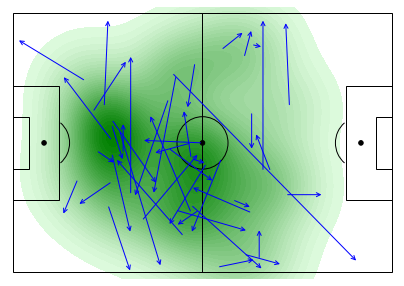

In [14]:
#draw passMap about all Pjanic passes
draw_HeatMap_PassMap(allPasses_pjanic)


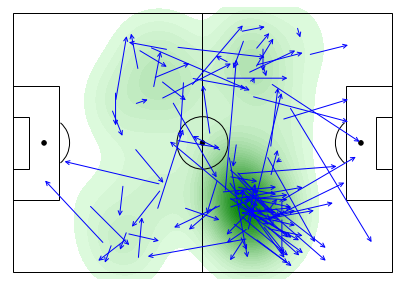

In [90]:
#draw passMap about all Jorginho passes
draw_HeatMap_PassMap(allPasses_jorginho)

We have calculated all right passes and all wroong passes taht Jorginho hase done respectively in the match. We have put these info in different dataframes.

In [93]:
#I put in 'allPasses_right_jorginho' dataframe all Jorginho accuratee passes 
allPasses_right_jorginho = pd.merge(allPasses_jorginho,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_right_jorginho=allPasses_right_jorginho.loc[(allPasses_right_jorginho['id']==1801)]
allPasses_right_jorginho

#I put in 'allPasses_wrong_jorginho' dataframe all Jorginho not accuratee passes 
allPasses_wrong_jorginho = pd.merge(allPasses_jorginho,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_wrong_jorginho=allPasses_wrong_jorginho.loc[(allPasses_wrong_jorginho['id']==1802)]
allPasses_wrong_jorginho

allPasses_right_jorginho.head()

subEventName eventName  playerId    eventSec  matchId   x   y  \
0  Simple pass      Pass     21315  166.338197  2576295  47  75   
1  Simple pass      Pass     21315  166.338197  2576295  62  71   
6  Simple pass      Pass     21315  250.114192  2576295  47  72   
7  Simple pass      Pass     21315  250.114192  2576295  61  96   
8  Simple pass      Pass     21315  446.557147  2576295  57  28   

                      label shortName subEventId    id  
0  Juventus - Napoli, 0 - 1  Jorginho         85  1801  
1  Juventus - Napoli, 0 - 1  Jorginho         85  1801  
6  Juventus - Napoli, 0 - 1  Jorginho         85  1801  
7  Juventus - Napoli, 0 - 1  Jorginho         85  1801  
8  Juventus - Napoli, 0 - 1  Jorginho         85  1801

In [92]:
#i put in 'allPasses_right_pjanic' dataframe all Pjanic accuratee passes 
allPasses_right_pjanic = pd.merge(allPasses_pjanic,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_right_pjanic=allPasses_right_pjanic.loc[(allPasses_right_pjanic['id']==1801)]
allPasses_right_pjanic

#I put in 'allPasses_wrong_pjanic' dataframe all Pjanic not accuratee passes 
allPasses_wrong_pjanic = pd.merge(allPasses_pjanic,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_wrong_pjanic=allPasses_wrong_pjanic.loc[(allPasses_wrong_pjanic['id']==1802)]

allPasses_wrong_pjanic.head()

subEventName eventName  playerId    eventSec  matchId   x   y  \
10  Simple pass      Pass     20443  352.941005  2576295  25  26   
13  Simple pass      Pass     20443  352.941005  2576295  31   0   

                       label       shortName    id  
10  Juventus - Napoli, 0 - 1  M. Pjani\u0107  1802  
13  Juventus - Napoli, 0 - 1  M. Pjani\u0107  1802

These two following figures represent:
* Pass map of Pjanic about "Juventus - Napoli played on the 22 April 2018"
* Pass map of Jorginho about "Juventus - Napoli played on the 22 April 2018"

In these two figures we have shown the difference between right and wrong passes.
Right passes = blue arrows
Wrong passes = red arrows

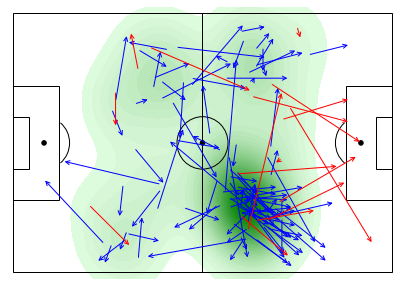

In [76]:

draw_HeatMap_PassMap2(allPasses_right_jorginho, allPasses_wrong_jorginho)

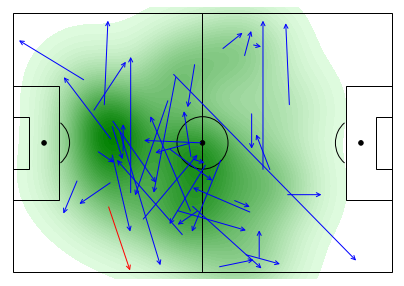

In [77]:
draw_HeatMap_PassMap2(allPasses_right_pjanic, allPasses_wrong_pjanic)